CT Reconstruction with TV Regularization
========================================

This example demonstrates the use of different optimization algorithms to
solve the TV-regularized CT problem, using SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, metric, plot
from scico.linop import Diagonal
from scico.linop.radon_svmbir import SVMBIRSquaredL2Loss, TomographicProjector
from scico.optimize import PDHG, LinearizedADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, dtype=snp.float32)
A = TomographicProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up problem.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

λ = 1e-1  # L1 norm regularization parameter

f = SVMBIRSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g = λ * functional.L21Norm()  # regularization functional

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

Solve via ADMM.

In [7]:
solve_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[2e1],
    x0=x0,
    maxiter=50,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 10}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
x_admm = solve_admm.solve()
hist_admm = solve_admm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_admm):.2f} dB\n")

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  6.89e+00  8.931e+00  6.585e-01  5.655e-01     10  1.146e-03


  10  5.91e+01  1.605e+01  2.440e-02  2.958e-02      9  8.826e-05


  20  9.05e+01  1.616e+01  1.224e-02  1.140e-02      4  7.769e-05


  30  1.13e+02  1.620e+01  7.851e-03  8.318e-04      0  9.838e-05


  40  1.27e+02  1.622e+01  6.424e-03  8.382e-03      4  5.438e-05


  49  1.35e+02  1.623e+01  4.803e-03  2.745e-03      2  9.397e-05


PSNR: 22.93 dB



Solve via Linearized ADMM.

In [8]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB\n")

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  4.04e+00  5.302e+00  1.071e+00  1.100e+00


  10  1.05e+01  1.539e+01  1.334e-01  5.320e-02


  20  1.68e+01  1.581e+01  5.610e-02  2.220e-02


  30  2.30e+01  1.594e+01  3.303e-02  1.149e-02


  40  2.84e+01  1.602e+01  2.346e-02  6.876e-03


  49  3.29e+01  1.607e+01  1.865e-02  4.825e-03
PSNR: 22.87 dB



Solve via PDHG.

In [9]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=2e-2,
    sigma=8e0,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB\n")

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  6.58e-01  2.246e+01  7.207e+00  1.057e+00


  10  6.93e+00  1.753e+01  1.775e+00  9.524e-02


  20  1.27e+01  1.676e+01  6.823e-01  4.009e-02


  30  1.81e+01  1.650e+01  2.988e-01  2.187e-02


  40  2.41e+01  1.640e+01  1.508e-01  1.472e-02


  49  2.91e+01  1.637e+01  9.201e-02  1.149e-02
PSNR: 22.92 dB



Show the recovered images.

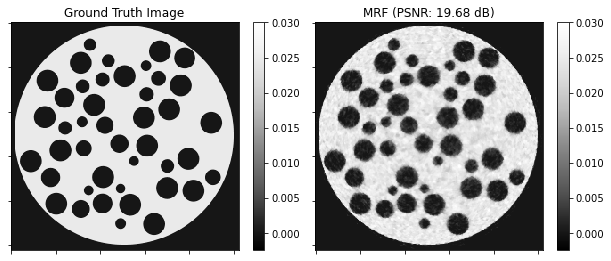

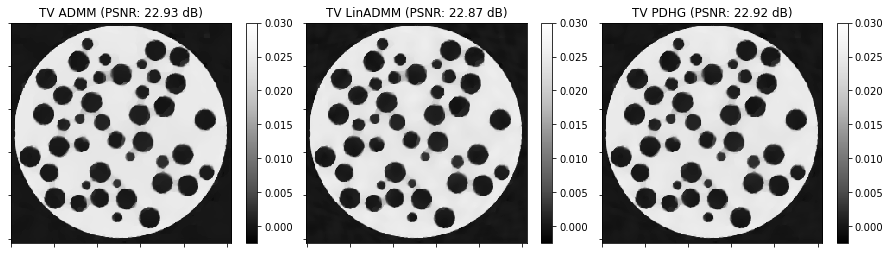

In [10]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
fig.show()

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(
    img=x_admm,
    title=f"TV ADMM (PSNR: {metric.psnr(x_gt, x_admm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0],
    norm=norm,
)
plot.imview(
    img=x_ladmm,
    title=f"TV LinADMM (PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_pdhg,
    title=f"TV PDHG (PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

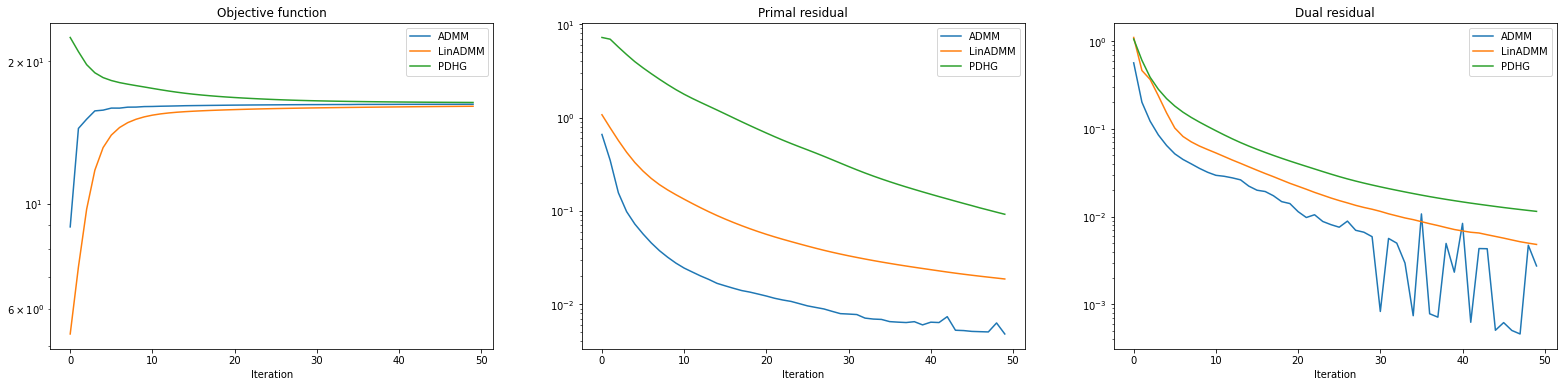

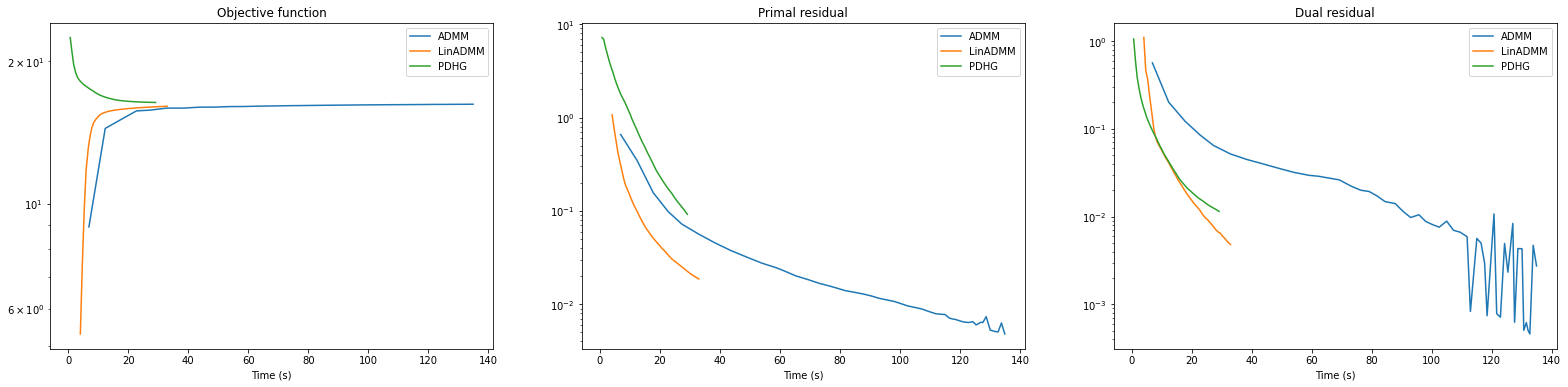

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()